# Finding key factors that predict an exoplanet's distance from its host star

### Group Name: SPACE!
Ben Rycroft (s3947135)

Rita Lam Cordeiro (s3471881)

### Introduction

**Dataset Source**

The NASA Exoplanet archive compiles data on all known exoplanets and their host stars including exoplanet parameters, stellar parameters and, discovery/characterization data. 

This archive includes three data sets: "List of All known planets and hosts", "List of all Kepler Objects of Interest (KOIs)", and "List of all Kepler Threshold-Crossing Events (TCEs). We have chosen to solely use "List of All known planets and hosts" for this project


**Dataset Details**

Each row in the dataset represents an exoplanet. This dataset has _ columns: 

Due to large amount of NaN values we have decided to split the data into subsets which focus on corellating a value with a planet's distance from its host star. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import io
import requests
from scipy.stats import linregress


pd.set_option('display.max_columns', None) 

###
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn")
###

In [2]:
#naming the dataset
df = pd.read_csv("https://raw.githubusercontent.com/BenRyc/SPACE-/main/orbitDistNoLim.csv")

## Data Cleaning and Preprocessing
Preparing the data for modelling

### Step 1
The https://exoplanetarchive.ipac.caltech.edu site where the data was colected from required us to specify what columns of the larger dataset that we needed to download. We only selected the relevent columns that we wanted to investegate and we also excluded datapoints like names of planets and stars. 

### Step 2 
Here are the columns of the dataset

In [8]:
df.columns

Index(['sy_snum', 'sy_pnum', 'discoverymethod', 'pl_orbper', 'pl_orbpererr1',
       'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2',
       'pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_masse', 'pl_masseerr1',
       'pl_masseerr2', 'pl_dens', 'pl_denserr1', 'pl_denserr2', 'pl_orbeccen',
       'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_insol', 'pl_insolerr1',
       'pl_insolerr2', 'pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_eqtlim',
       'st_spectype', 'st_teff', 'st_tefferr1', 'st_tefferr2', 'st_rad',
       'st_raderr1', 'st_raderr2', 'st_mass', 'st_masserr1', 'st_masserr2',
       'st_met', 'st_meterr1', 'st_meterr2', 'st_metlim', 'st_logg',
       'st_loggerr1', 'st_loggerr2', 'st_age', 'st_ageerr1', 'st_ageerr2',
       'st_agelim', 'st_dens', 'st_denserr1', 'st_denserr2', 'sy_dist',
       'sy_disterr1', 'sy_disterr2'],
      dtype='object')

There are many different variables that we intend to compare to orbit and not every row has values for every column this is why we decided to split the dataset into lots of smaller datasets each only compairing one verable against the orbit radius. This way we can remove all the rows with null values from each of the datasubsets without removing the rows from other datasubsets. 

In [3]:
rad = df.dropna(subset=['pl_rade', 'pl_radeerr1', 'pl_radeerr2'])
mass = df.dropna(subset=['pl_masse', 'pl_masseerr1', 'pl_masseerr2'])
dens = df.dropna(subset=['pl_dens', 'pl_denserr1', 'pl_denserr2'])
orbeccen = df.dropna(subset=['pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2'])
insol = df.dropna(subset=['pl_insol', 'pl_insolerr1', 'pl_insolerr2'])
eqt = df.dropna(subset=['pl_eqt', 'pl_eqterr1', 'pl_eqterr2'])
teff = df.dropna(subset=['st_teff', 'st_tefferr1', 'st_tefferr2'])
radst = df.dropna(subset=['st_rad', 'st_raderr1', 'st_raderr2'])
massst = df.dropna(subset=['st_mass', 'st_masserr1', 'st_masserr2'])
met = df.dropna(subset=['st_met', 'st_meterr1', 'st_meterr2'])
agest = df.dropna(subset=['st_age', 'st_ageerr1', 'st_ageerr2'])

### Step 3 
Next was to only include the relevant columns in each data subset

In [4]:
rad = rad[['pl_rade', 'pl_radeerr1', 'pl_radeerr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
mass = mass[['pl_masse', 'pl_masseerr1', 'pl_masseerr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
dens = dens[['pl_dens', 'pl_denserr1', 'pl_denserr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
orbeccen = orbeccen[['pl_orbeccen', 'pl_orbeccenerr1', 'pl_orbeccenerr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
insol = insol[['pl_insol', 'pl_insolerr1', 'pl_insolerr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
eqt = eqt[['pl_eqt', 'pl_eqterr1', 'pl_eqterr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
teff = teff[['st_teff', 'st_tefferr1', 'st_tefferr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
radst = radst[['st_rad', 'st_raderr1', 'st_raderr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
massst = massst[['st_mass', 'st_masserr1', 'st_masserr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
met = met[['st_met', 'st_meterr1', 'st_meterr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]
agest = agest[['st_age', 'st_ageerr1', 'st_ageerr2', 'pl_orbper', 'pl_orbpererr1', 'pl_orbpererr2', 'pl_orbsmax', 'pl_orbsmaxerr1', 'pl_orbsmaxerr2']]


## Step 4 
No we removed the outlighers from the data

In [26]:

rad = rad[~((rad < (rad.quantile(0.25) - 1.5 * (rad.quantile(0.75) - rad.quantile(0.25)))) |(rad > (rad.quantile(0.75) + 1.5 * (rad.quantile(0.75) - rad.quantile(0.25))))).any(axis=1)]
mass = mass[~((mass < (mass.quantile(0.25) - 1.5 * (mass.quantile(0.75) - mass.quantile(0.25)))) |(mass > (mass.quantile(0.75) + 1.5 * (mass.quantile(0.75) - mass.quantile(0.25))))).any(axis=1)]
dens = dens[~((dens < (dens.quantile(0.25) - 1.5 * (dens.quantile(0.75) - dens.quantile(0.25)))) |(dens > (dens.quantile(0.75) + 1.5 * (dens.quantile(0.75) - dens.quantile(0.25))))).any(axis=1)]
orbeccen = orbeccen[~((orbeccen < (orbeccen.quantile(0.25) - 1.5 * (orbeccen.quantile(0.75) - orbeccen.quantile(0.25)))) |(orbeccen > (orbeccen.quantile(0.75) + 1.5 * (orbeccen.quantile(0.75) - orbeccen.quantile(0.25))))).any(axis=1)]
insol = insol[~((insol < (insol.quantile(0.25) - 1.5 * (insol.quantile(0.75) - insol.quantile(0.25)))) |(insol > (insol.quantile(0.75) + 1.5 * (insol.quantile(0.75) - insol.quantile(0.25))))).any(axis=1)]
eqt = eqt[~((eqt < (eqt.quantile(0.25) - 1.5 * (eqt.quantile(0.75) - eqt.quantile(0.25)))) |(eqt > (eqt.quantile(0.75) + 1.5 * (eqt.quantile(0.75) - eqt.quantile(0.25))))).any(axis=1)]
teff = teff[~((teff < (teff.quantile(0.25) - 1.5 * (teff.quantile(0.75) - teff.quantile(0.25)))) |(teff > (teff.quantile(0.75) + 1.5 * (teff.quantile(0.75) - teff.quantile(0.25))))).any(axis=1)]
radst = radst[~((radst < (radst.quantile(0.25) - 1.5 * (radst.quantile(0.75) - radst.quantile(0.25)))) |(radst > (radst.quantile(0.75) + 1.5 * (radst.quantile(0.75) - radst.quantile(0.25))))).any(axis=1)]
massst = massst[~((massst < (massst.quantile(0.25) - 1.5 * (massst.quantile(0.75) - massst.quantile(0.25)))) |(massst > (massst.quantile(0.75) + 1.5 * (massst.quantile(0.75) - massst.quantile(0.25))))).any(axis=1)]
met = met[~((met < (met.quantile(0.25) - 1.5 * (met.quantile(0.75) - met.quantile(0.25)))) |(met > (met.quantile(0.75) + 1.5 * (met.quantile(0.75) - met.quantile(0.25))))).any(axis=1)]
agest = agest[~((agest < (agest.quantile(0.25) - 1.5 * (agest.quantile(0.75) - agest.quantile(0.25)))) |(agest > (agest.quantile(0.75) + 1.5 * (agest.quantile(0.75) - agest.quantile(0.25))))).any(axis=1)]


## Data Visualisation 

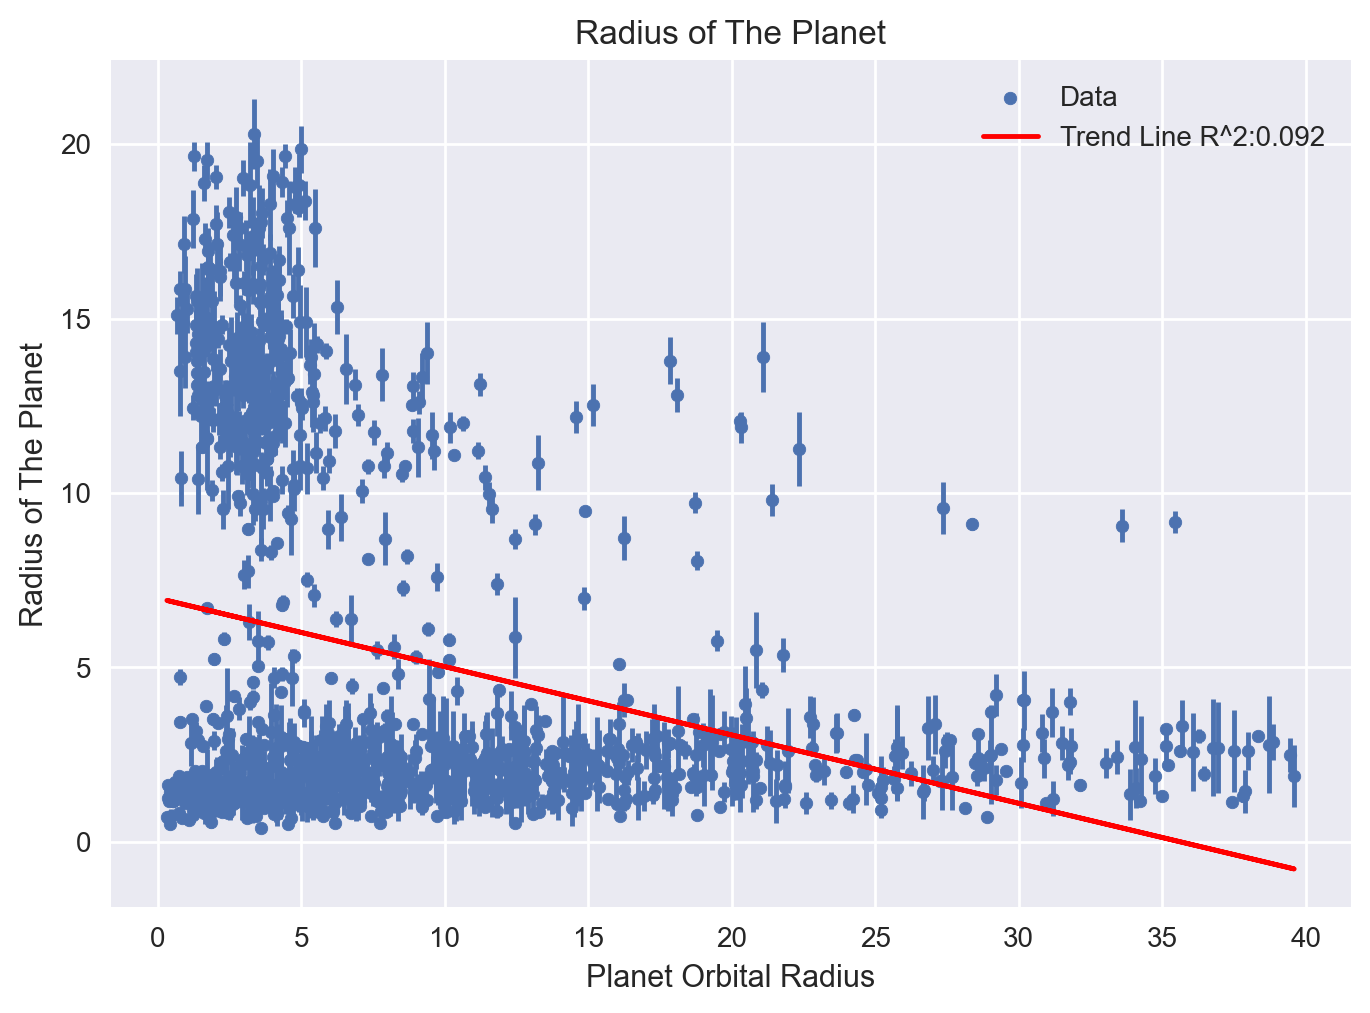

In [25]:
slope, intercept, r_value, p_value, std_err = linregress(rad['pl_orbper'], rad['pl_rade'])
rad.plot(kind = 'scatter', 
         x = 'pl_orbper', 
         y = 'pl_rade', 

         xerr=rad['pl_orbpererr1'], 
         yerr=rad['pl_radeerr1'],
         ylabel= 'Radius of The Planet',
         xlabel= 'Planet Orbital Radius',
         title='Radius of The Planet')

plt.plot(rad['pl_orbper'], intercept + slope*rad['pl_orbper'], 'r', label='fitted line')
plt.legend(['Data', f'Trend Line R^2:{str(r_value**2)[0:5]}'])
plt.show()

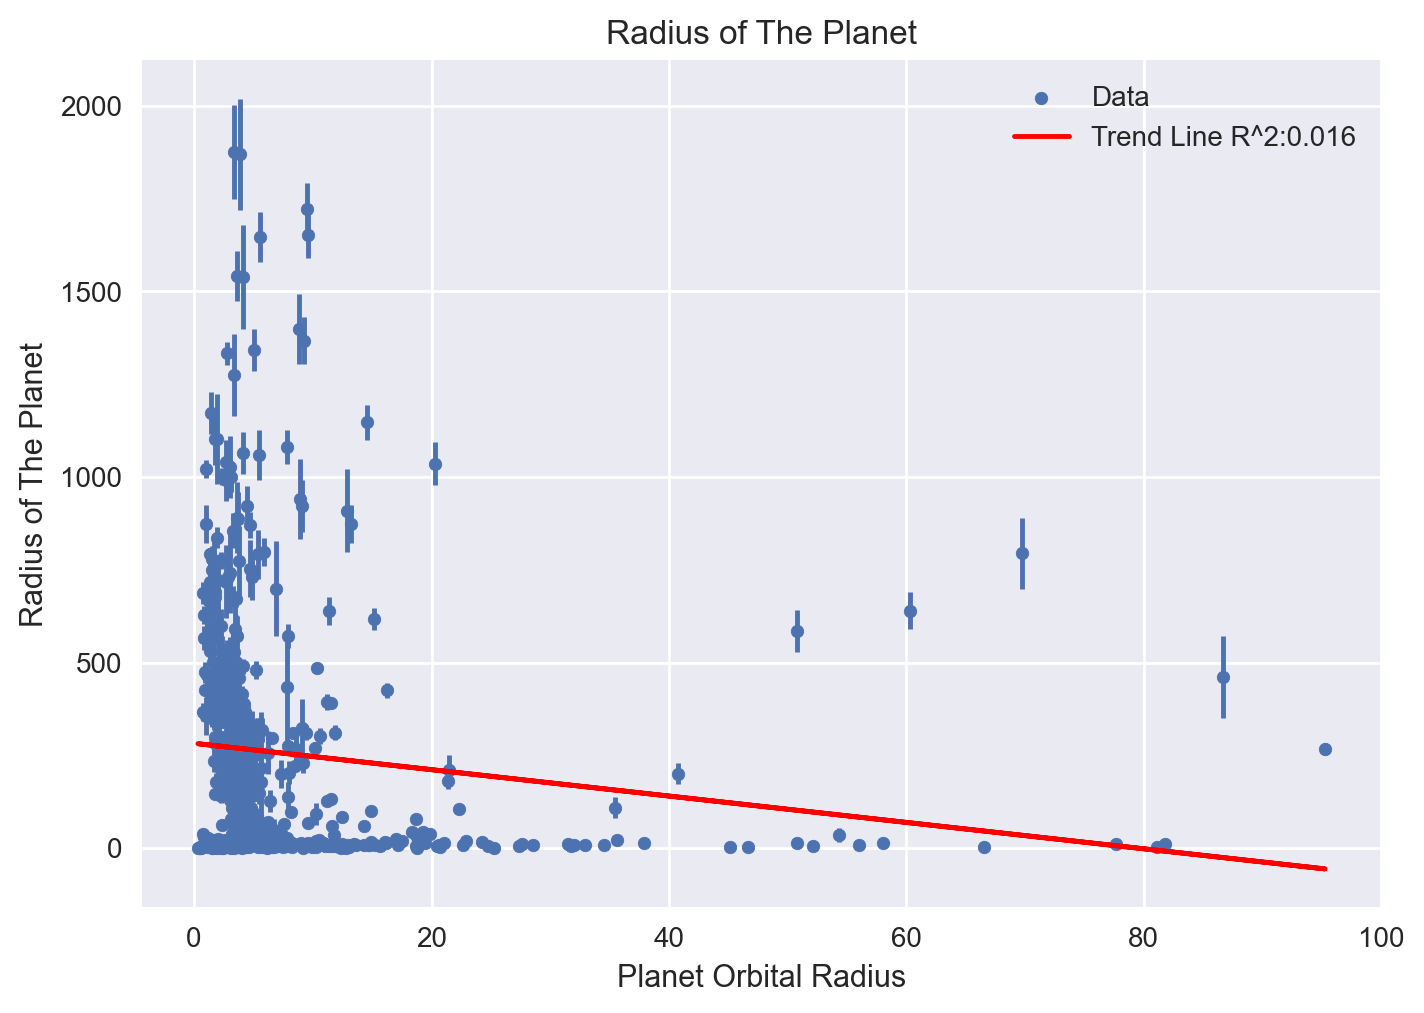

In [27]:
slope, intercept, r_value, p_value, std_err = linregress(mass['pl_orbper'], mass['pl_masse'])
mass.plot(kind = 'scatter', 
         x = 'pl_orbper', 
         y = 'pl_masse', 
         xerr=mass['pl_orbpererr1'], 
         yerr=mass['pl_masseerr1'],
         ylabel= 'Radius of The Planet',
         xlabel= 'Planet Orbital Radius',
         title='Radius of The Planet')

plt.plot(mass['pl_orbper'], intercept + slope*mass['pl_orbper'], 'r', label='fitted line')
plt.legend(['Data', f'Trend Line R^2:{str(r_value**2)[0:5]}'])
plt.show()

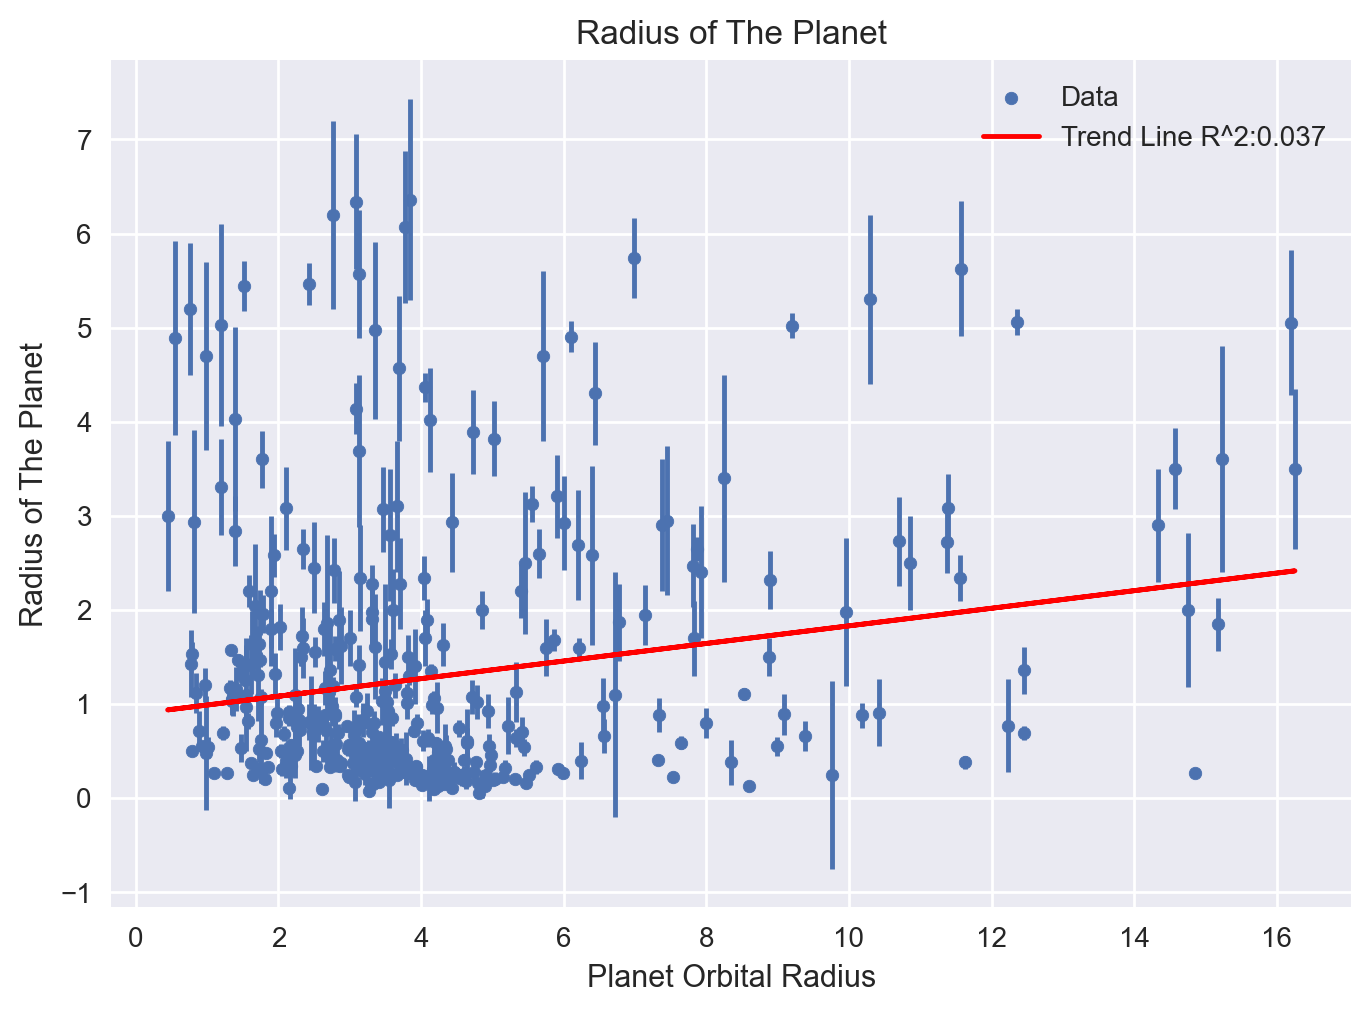

In [28]:
slope, intercept, r_value, p_value, std_err = linregress(dens['pl_orbper'], dens['pl_dens'])
dens.plot(kind = 'scatter', 
         x = 'pl_orbper', 
         y = 'pl_dens', 
         xerr=dens['pl_orbpererr1'], 
         yerr=dens['pl_denserr1'],
         ylabel= 'Radius of The Planet',
         xlabel= 'Planet Orbital Radius',
         title='Radius of The Planet')

plt.plot(dens['pl_orbper'], intercept + slope*dens['pl_orbper'], 'r', label='fitted line')
plt.legend(['Data', f'Trend Line R^2:{str(r_value**2)[0:5]}'])
plt.show()

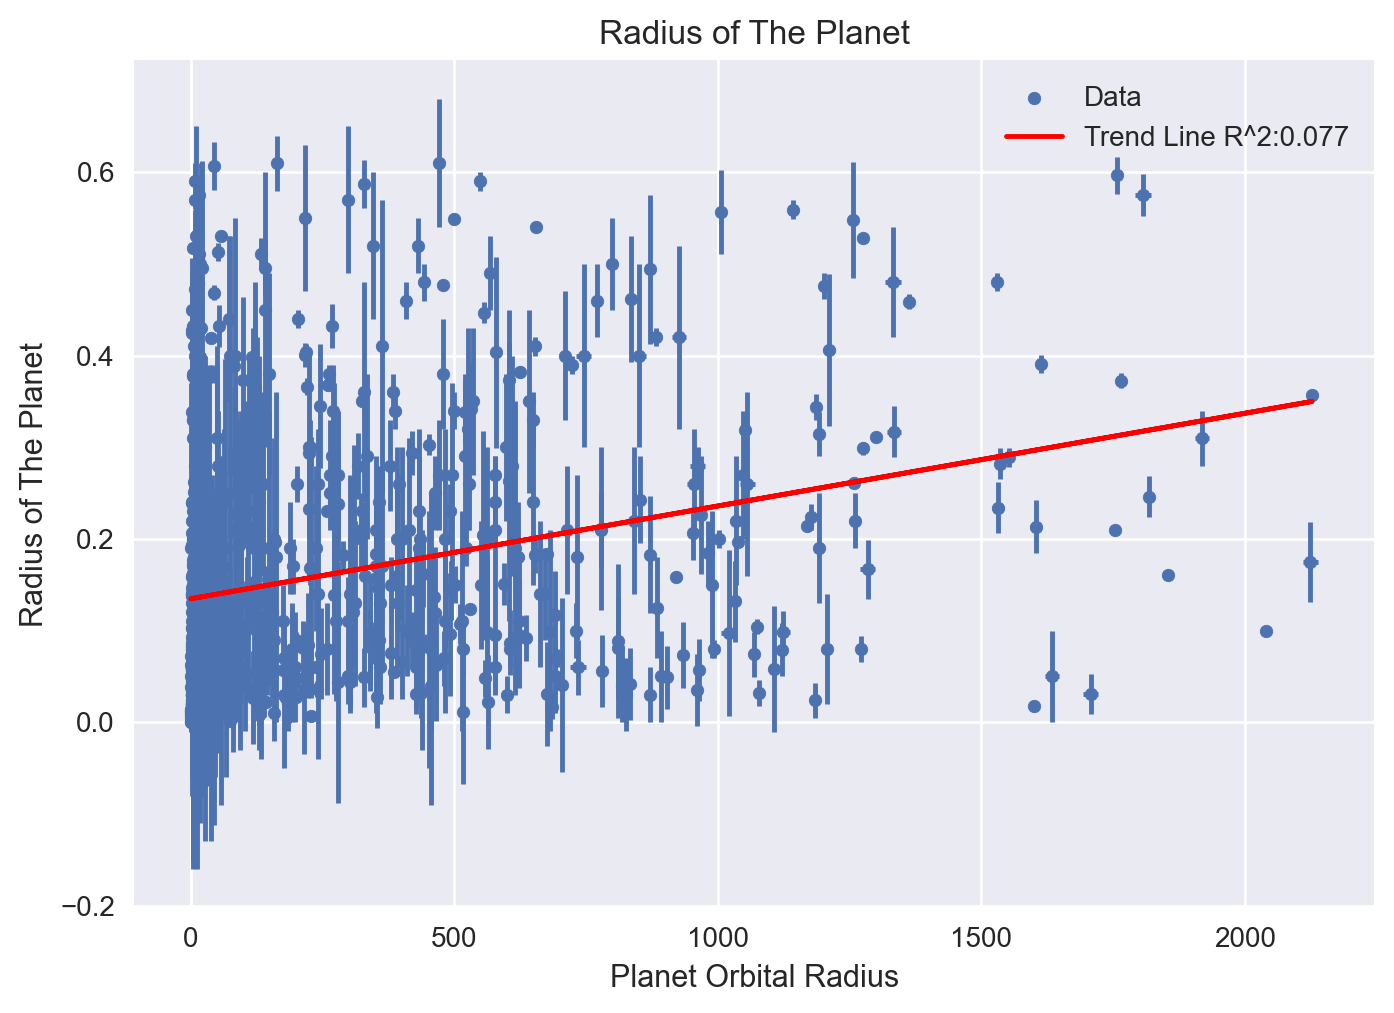

In [29]:
slope, intercept, r_value, p_value, std_err = linregress(orbeccen['pl_orbper'], orbeccen['pl_orbeccen'])
orbeccen.plot(kind = 'scatter', 
         x = 'pl_orbper', 
         y = 'pl_orbeccen', 
         xerr=orbeccen['pl_orbpererr1'], 
         yerr=orbeccen['pl_orbeccenerr1'],
         ylabel= 'Radius of The Planet',
         xlabel= 'Planet Orbital Radius',
         title='Radius of The Planet')

plt.plot(orbeccen['pl_orbper'], intercept + slope*orbeccen['pl_orbper'], 'r', label='fitted line')
plt.legend(['Data', f'Trend Line R^2:{str(r_value**2)[0:5]}'])
plt.show()

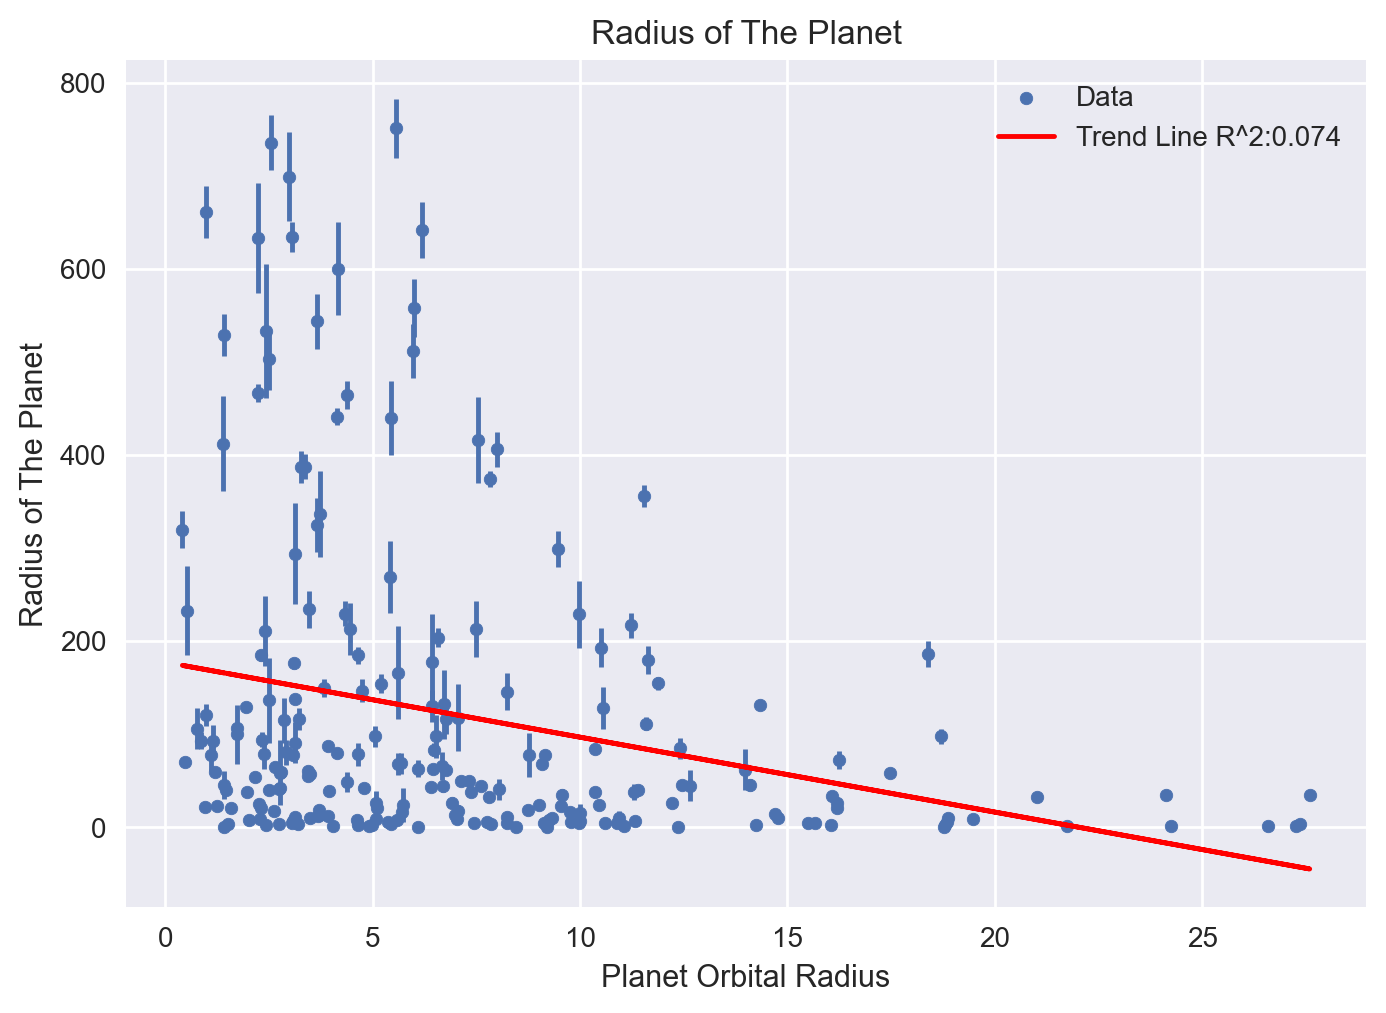

In [44]:
slope, intercept, r_value, p_value, std_err = linregress(insol['pl_orbper'], insol['pl_insol'])

insol.plot(kind = 'scatter', 
         x = 'pl_orbper', 
         y = 'pl_insol', 
         xerr=insol['pl_orbpererr1'], 
         yerr=insol['pl_insolerr1'],
         ylabel= 'Radius of The Planet',
         xlabel= 'Planet Orbital Radius',
         title='Radius of The Planet')

plt.plot(insol['pl_orbper'], intercept + slope*insol['pl_orbper'], 'r', label='fitted line')
plt.legend(['Data', f'Trend Line R^2:{str(r_value**2)[0:5]}'])
plt.show()

-52.35348116865932 1470.1540344284947


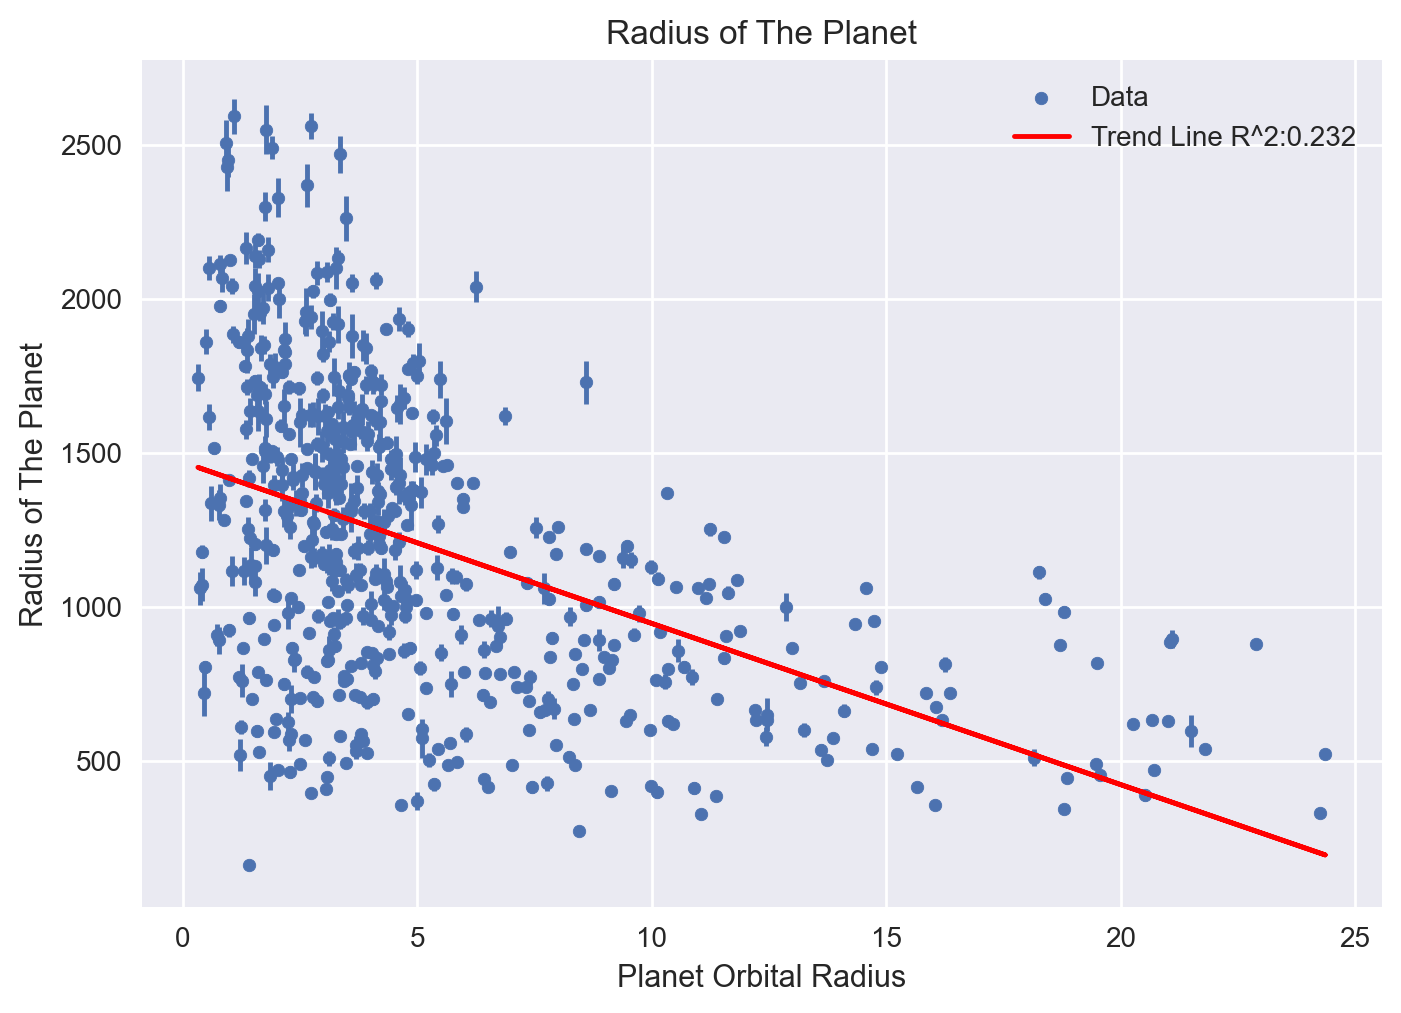

In [31]:
slope, intercept, r_value, p_value, std_err = linregress(eqt['pl_orbper'], eqt['pl_eqt'])
eqt.plot(kind = 'scatter', 
         x = 'pl_orbper', 
         y = 'pl_eqt', 
         xerr=eqt['pl_orbpererr1'], 
         yerr=eqt['pl_eqterr1'],
         ylabel= 'Radius of The Planet',
         xlabel= 'Planet Orbital Radius',
         title='Radius of The Planet')

plt.plot(eqt['pl_orbper'], intercept + slope*eqt['pl_orbper'], 'r', label='fitted line')
plt.legend(['Data', f'Trend Line R^2:{str(r_value**2)[0:5]}'])
plt.show()

5.517119523402608 5209.254879426635


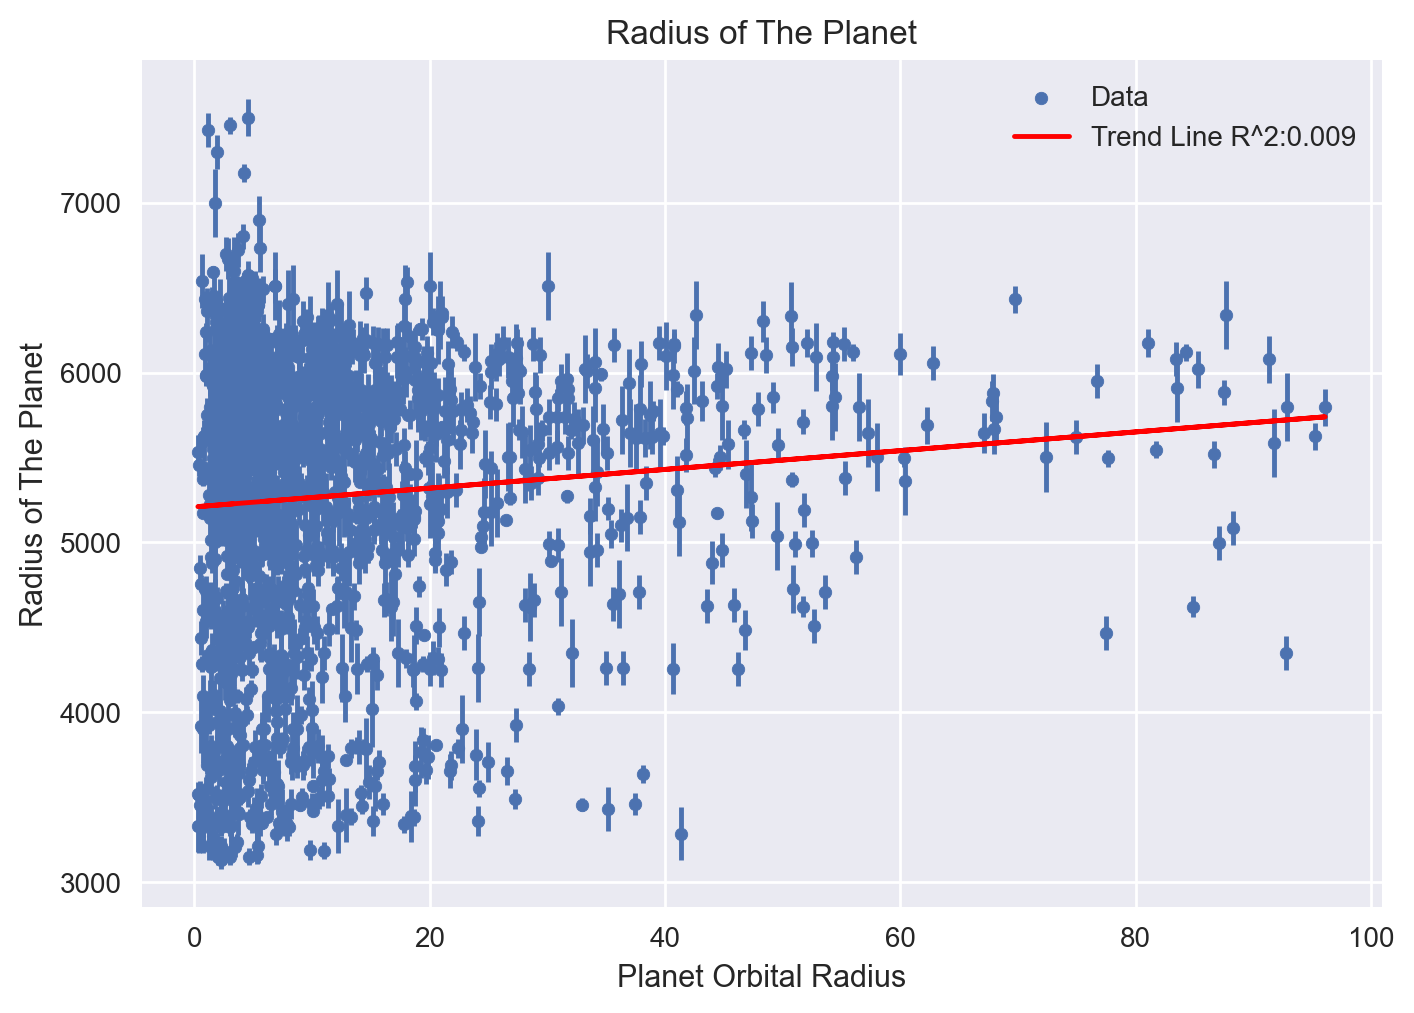

In [35]:
slope, intercept, r_value, p_value, std_err = linregress(teff['pl_orbper'], teff['st_teff'])
teff.plot(kind = 'scatter', 
         x = 'pl_orbper', 
         y = 'st_teff', 
         xerr=teff['pl_orbpererr1'], 
         yerr=teff['st_tefferr1'],
         ylabel= 'Radius of The Planet',
         xlabel= 'Planet Orbital Radius',
         title='Radius of The Planet')

plt.plot(teff['pl_orbper'], intercept + slope*teff['pl_orbper'], 'r', label='fitted line')
plt.legend(['Data', f'Trend Line R^2:{str(r_value**2)[0:5]}'])
plt.show()

0.0010661557877568232 0.948443948276003


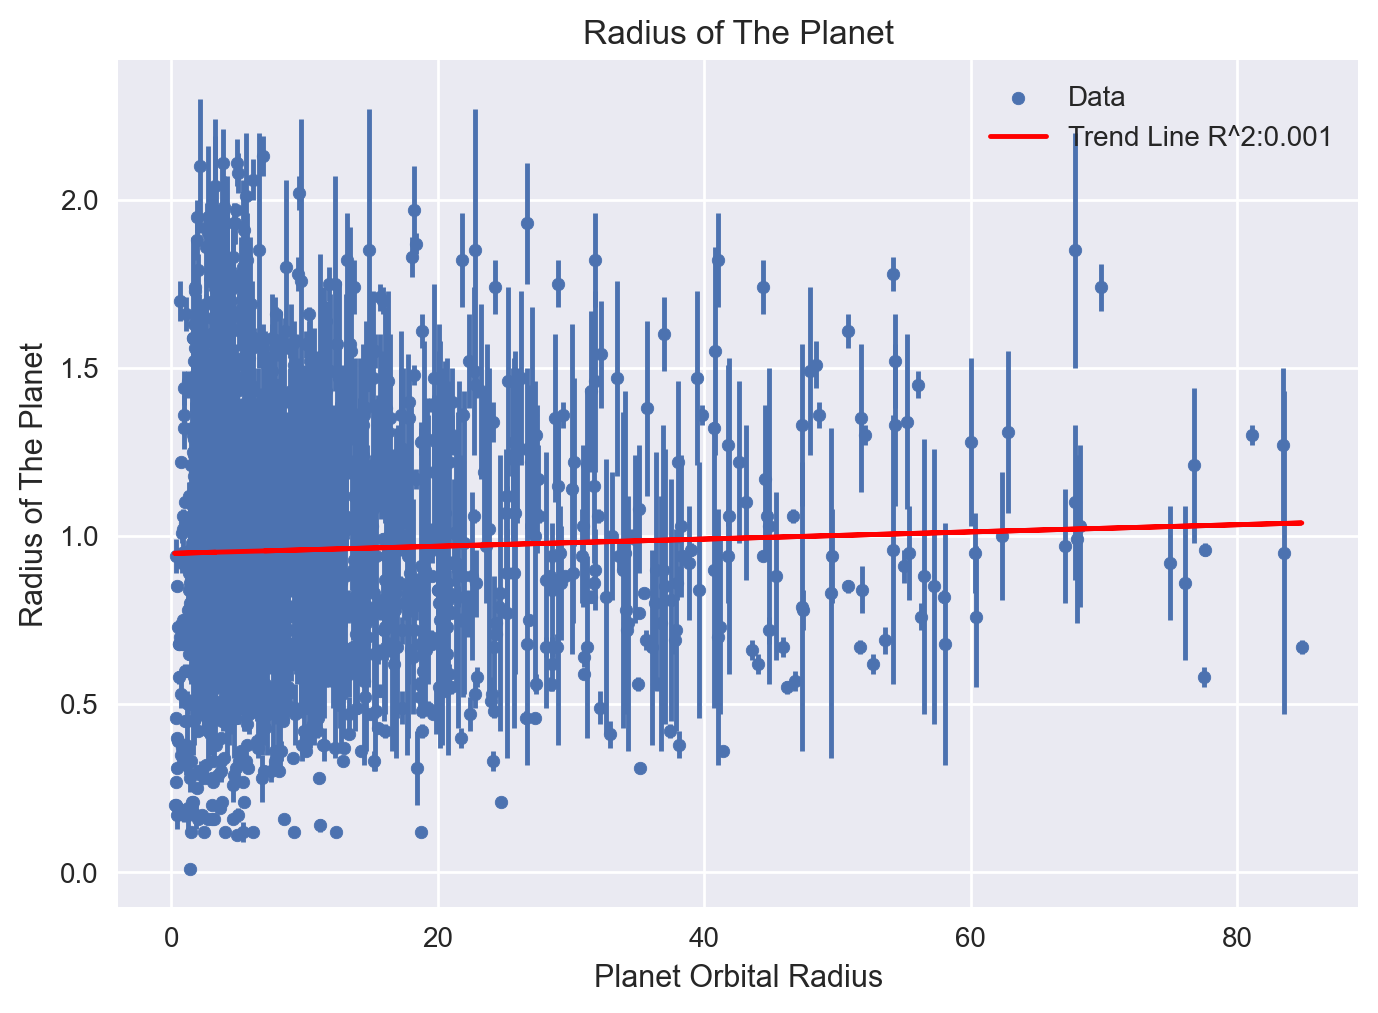

In [37]:
slope, intercept, r_value, p_value, std_err = linregress(radst['pl_orbper'], radst['st_rad'])
radst.plot(kind = 'scatter', 
         x = 'pl_orbper', 
         y = 'st_rad', 
         xerr=radst['pl_orbpererr1'], 
         yerr=radst['st_raderr1'],
         ylabel= 'Radius of The Planet',
         xlabel= 'Planet Orbital Radius',
         title='Radius of The Planet')

plt.plot(radst['pl_orbper'], intercept + slope*radst['pl_orbper'], 'r', label='fitted line')
plt.legend(['Data', f'Trend Line R^2:{str(r_value**2)[0:5]}'])
plt.show()

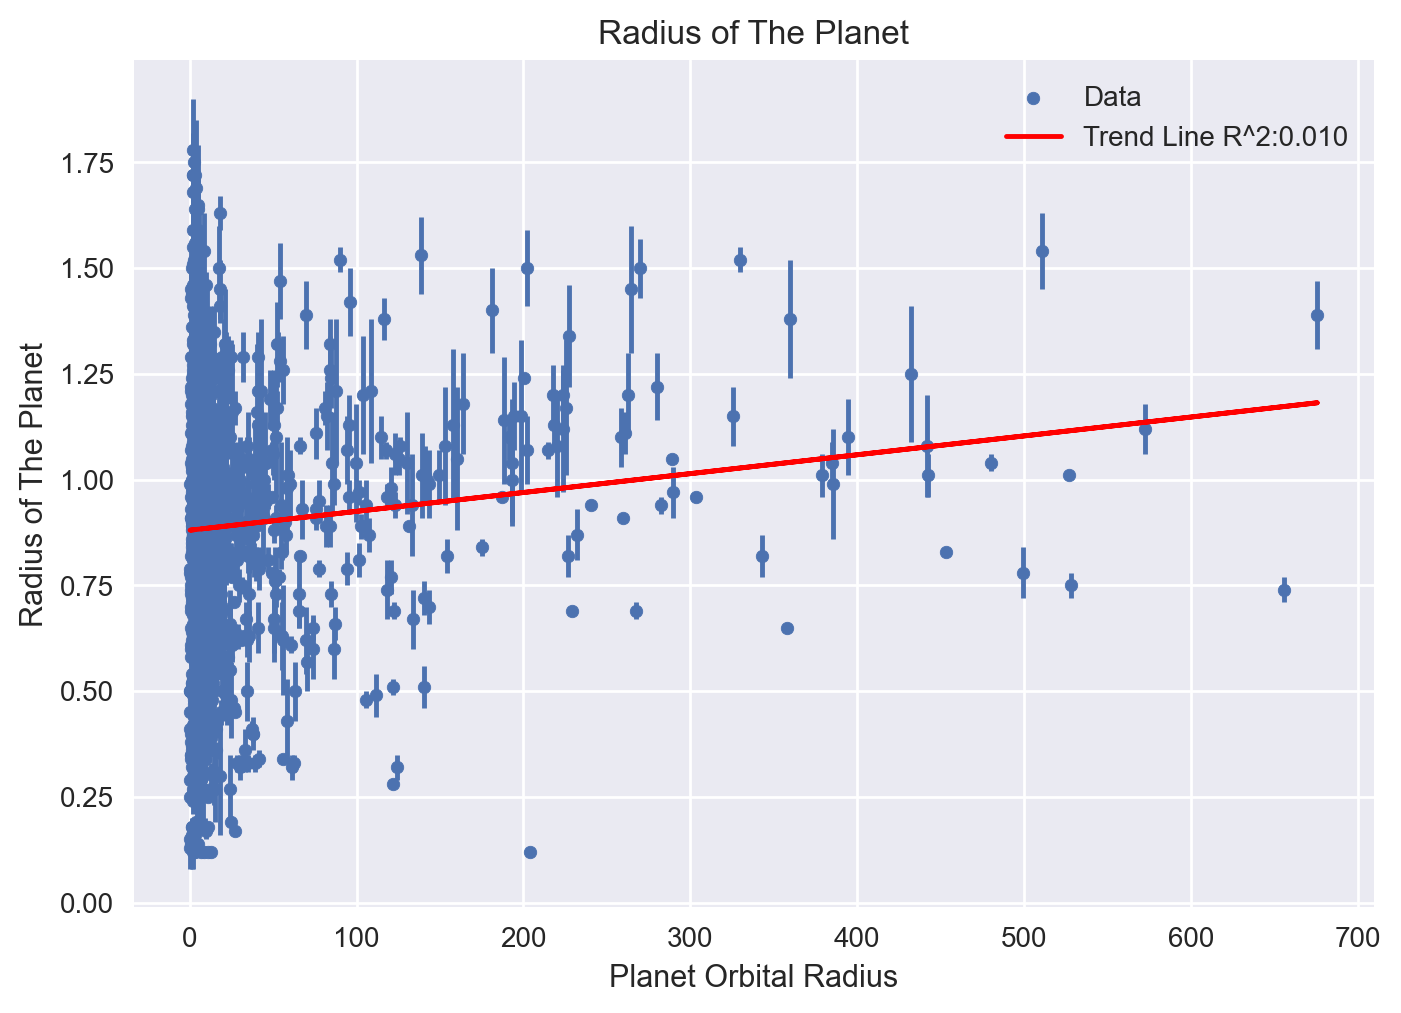

In [39]:
slope, intercept, r_value, p_value, std_err = linregress(massst['pl_orbper'], massst['st_mass'])
massst.plot(kind = 'scatter', 
         x = 'pl_orbper', 
         y = 'st_mass', 
         xerr=massst['pl_orbpererr1'], 
         yerr=massst['st_masserr1'],
         ylabel= 'Radius of The Planet',
         xlabel= 'Planet Orbital Radius',
         title='Radius of The Planet')

plt.plot(massst['pl_orbper'], intercept + slope*massst['pl_orbper'], 'r', label='fitted line')
plt.legend(['Data', f'Trend Line R^2:{str(r_value**2)[0:5]}'])
plt.show()

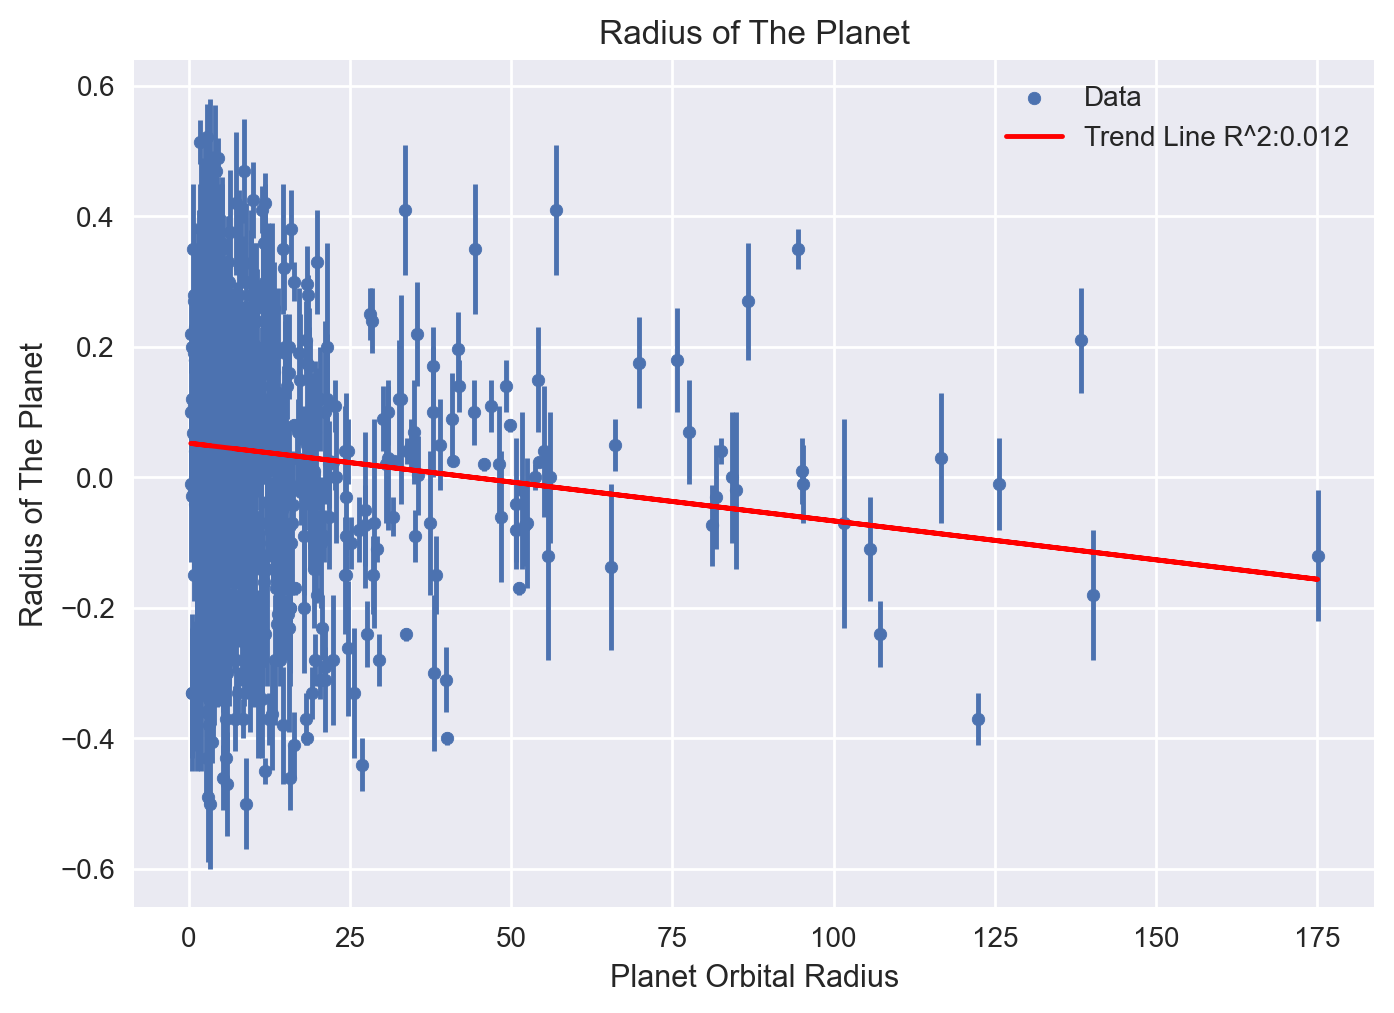

In [41]:
slope, intercept, r_value, p_value, std_err = linregress(met['pl_orbper'], met['st_met'])
met.plot(kind = 'scatter', 
         x = 'pl_orbper', 
         y = 'st_met', 
         xerr=met['pl_orbpererr1'], 
         yerr=met['st_meterr1'],
         ylabel= 'Radius of The Planet',
         xlabel= 'Planet Orbital Radius',
         title='Radius of The Planet')

plt.plot(met['pl_orbper'], intercept + slope*met['pl_orbper'], 'r', label='fitted line')
plt.legend(['Data', f'Trend Line R^2:{str(r_value**2)[0:5]}'])
plt.show()

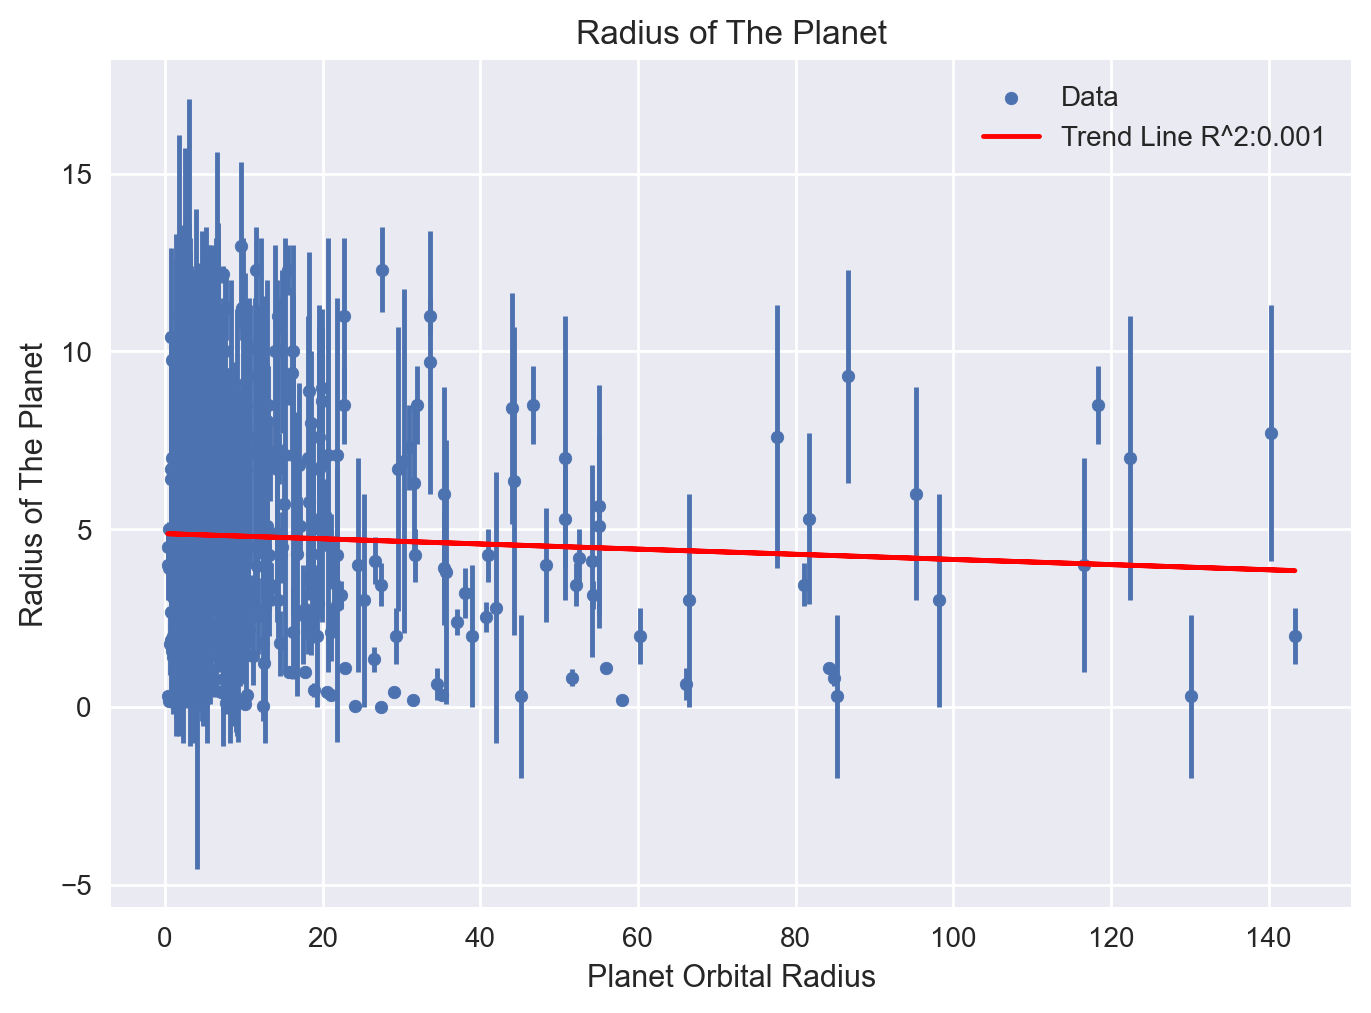

In [43]:
slope, intercept, r_value, p_value, std_err = linregress(agest['pl_orbper'], agest['st_age'])
agest.plot(kind = 'scatter', 
         x = 'pl_orbper', 
         y = 'st_age', 
         xerr=agest['pl_orbpererr1'], 
         yerr=agest['st_ageerr1'],
         ylabel= 'Radius of The Planet',
         xlabel= 'Planet Orbital Radius',
         title='Radius of The Planet')

plt.plot(agest['pl_orbper'], intercept + slope*agest['pl_orbper'], 'r', label='fitted line')
plt.legend(['Data', f'Trend Line R^2:{str(r_value**2)[0:5]}'])
plt.show()